<a href="https://colab.research.google.com/github/sange243/golay/blob/MAIN/Copy_of_flood_detection_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install catboost
!pip install ppscore
!pip install pandas === 1.5.3
!pip install --upgrade --force-reinstall numpy pandas
!pip install --force-reinstall numpy==1.23.5


In [ ]:
# Data manipulation
#==============================================================================
import pandas as pd
import numpy as np

# Data visualization
#==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
#==============================================================================
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import ppscore as pps

# Data preprocessing
#==============================================================================
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
# Models
#==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
#==============================================================================
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# tqdm
#==============================================================================
from tqdm.notebook import tqdm_notebook

# warnings
#==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

# Corrected file path with proper function syntax
data = pd.read_excel("//content/MLPC_Flood_Dataset (1).xlsx")

# Display the first 5 rows of the dataset
data.head()


,X,Y,Slope,Curvature,Aspect,TWI,FA,Drainage,Rainfall,SUSCEP
0,3.909444,7.443056,46.686142,-3.888000e+09,45.000000,-3.250368,147.0,228.8528,101.515616,Very_High
1,3.908611,7.442778,52.151768,1.296000e+09,60.945396,-4.313832,61.0,229.6781,80.409863,Very_High
2,3.908889,7.442778,66.484085,0.000000e+00,67.619865,-8.327622,1.0,230.5920,78.986849,Very_High
3,3.909167,7.442778,58.007183,-2.592000e+09,38.659809,-4.707937,51.0,235.4210,81.953151,Very_High
4,3.909444,7.442778,60.503792,-1.296000e+09,351.869904,-5.985817,15.0,234.4346,85.866027,Very_High


In [ ]:
rows, cols = data.shape[0], data.shape[1]

print(f'rows: {rows}')
print(f'cols: {cols}')

rows: 144401
cols: 10


In [ ]:
print("##" * 30)
print(" " * 17, "Data set Information")
print("##" * 30)
print(data.info())


############################################################
                  Data set Information
############################################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144401 entries, 0 to 144400
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   X           144401 non-null  float64
 1   Y           144401 non-null  float64
 2   Slope       144119 non-null  float64
 3   Curvature   144401 non-null  float64
 4   Aspect      144401 non-null  float64
 5   TWI         144401 non-null  float64
 6   FA          144401 non-null  float64
 7   Drainage    144401 non-null  float64
 8   Rainfall    144401 non-null  float64
 9   SUSCEP      144401 non-null  object 
dtypes: float64(9), object(1)
memory usage: 11.0+ MB
None


In [ ]:
print(data.duplicated().sum())

0


In [ ]:
df_null_values = data.isnull().sum().to_frame().rename(columns = {0:'count'})
df_null_values['%'] = (df_null_values['count'] / len(data)) * 100
df_null_values = df_null_values.sort_values('%', ascending = False)
df_null_values.style.background_gradient(cmap = 'Spectral')

,count,%
Slope,282,0.195290
X,0,0.000000
Y,0,0.000000
Curvature,0,0.000000
Aspect,0,0.000000
TWI,0,0.000000
FA,0,0.000000
Drainage,0,0.000000
Rainfall,0,0.000000
SUSCEP,0,0.000000


In [ ]:
numerical_features = data.select_dtypes(include = ['int', 'float']).columns.to_list()

print(f'Total Numerical features = {len(numerical_features)}')

Total Numerical features = 9


In [ ]:
categorical_feature = data.select_dtypes(include = ['object', 'category']).columns.to_list()

print(f'Total Categorical feature = {len(categorical_feature)}')

Total Categorical feature = 1


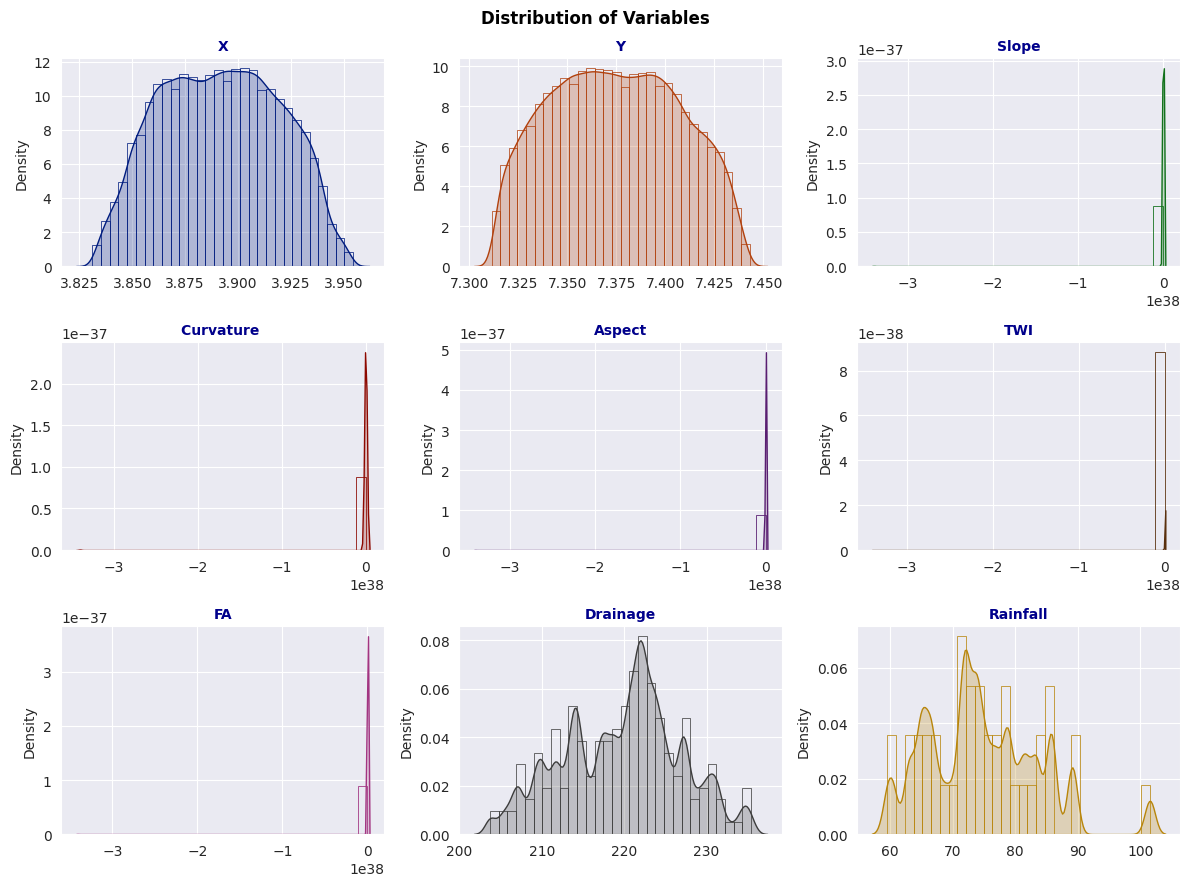

In [ ]:
sns.set_style("darkgrid")

colors = sns.color_palette(palette = 'dark', n_colors = len(numerical_features))

fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 9))
axs = axs.flat

for i,num_feat in enumerate(numerical_features):
    sns.kdeplot(data, x = num_feat, fill = True, color = colors[i], ax = axs[i])
    sns.histplot(data, x = num_feat,bins = 30, stat = 'density', fill = False, color = colors[i], ax = axs[i])
    axs[i].set_xlabel("")
    axs[i].set_title(num_feat, fontsize = 10, fontweight = 'bold', color = 'darkblue')

fig.suptitle("Distribution of Variables", fontsize = 12, fontweight = 'bold', color = 'black')
fig.tight_layout()
fig.show()

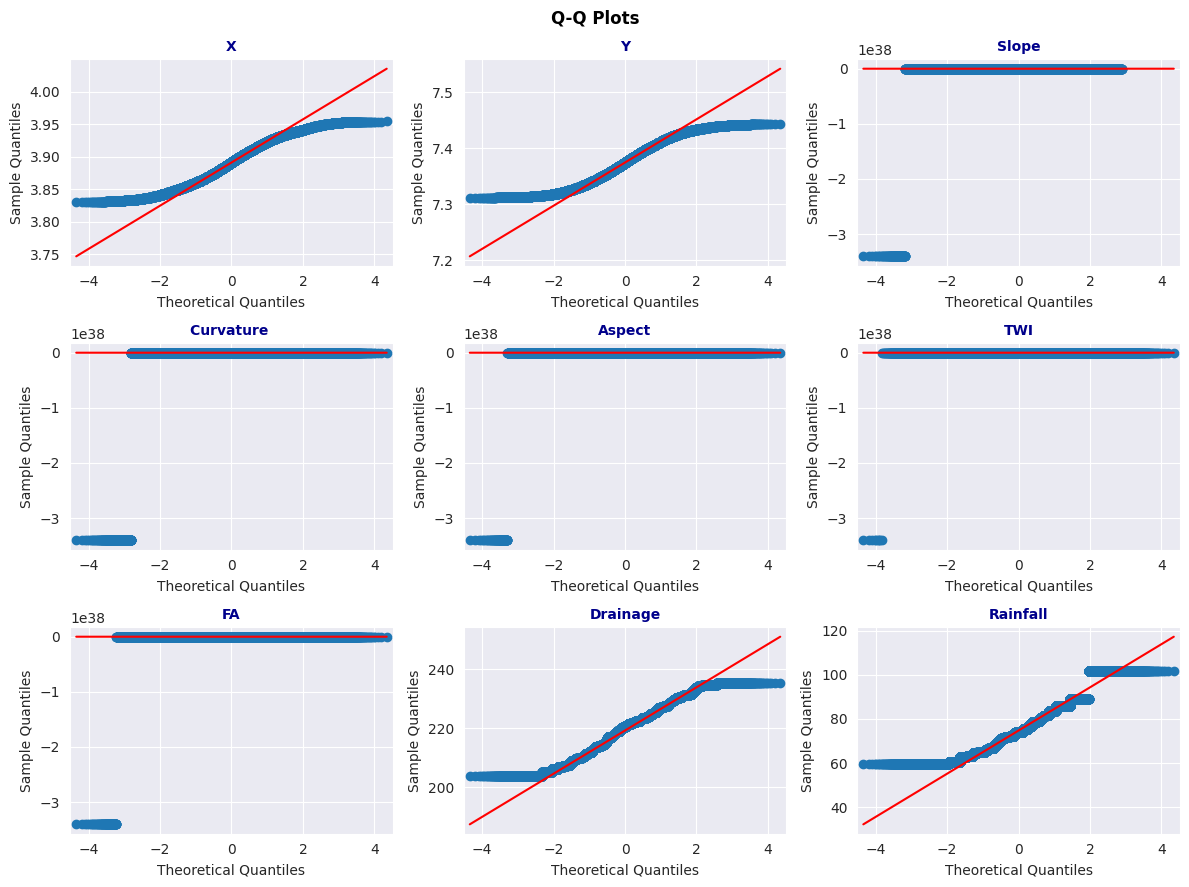

In [ ]:
fig,axs = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 9))
axs = axs.flat

for i,num_feat in enumerate(numerical_features):
    sm.qqplot(data[num_feat], line = 'q', ax = axs[i], lw = 2.1)
    axs[i].set_title(num_feat, fontsize = 10, fontweight = 'bold', color = 'darkblue')

fig.suptitle("Q-Q Plots", fontsize = 12, fontweight = 'bold', color = 'black')
fig.tight_layout()
fig.show()

In [ ]:
data[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
X,144401.0,3.891534e+00,2.788682e-02,3.831111e+00,3.868889e+00,3.891667,3.913611e+00,3.954444e+00
Y,144401.0,7.374551e+00,3.245907e-02,7.311389e+00,7.348333e+00,7.374167,7.400278e+00,7.443056e+00
Slope,144119.0,-2.502788e+35,9.225150e+36,-3.402823e+38,5.105756e+01,61.980232,6.916712e+01,8.657541e+01
Curvature,144401.0,-8.342043e+35,1.682769e+37,-3.402823e+38,-2.592000e+09,0.000000,2.592000e+09,3.888000e+10
Aspect,144401.0,-1.673122e+35,7.543591e+36,-3.402823e+38,1.013099e+02,189.462326,2.700000e+02,3.591449e+02
TWI,144401.0,-2.120858e+34,2.686356e+36,-3.402823e+38,-8.654586e+00,-8.006991,-6.709276e+00,1.168344e+01
FA,144401.0,-2.120858e+35,8.492619e+36,-3.402823e+38,0.000000e+00,1.000000,6.000000e+00,4.579360e+05
Drainage,144401.0,2.197145e+02,7.057921e+00,2.037293e+02,2.142869e+02,220.631300,2.241914e+02,2.354210e+02
Rainfall,144401.0,7.478693e+01,8.891617e+00,5.954110e+01,6.814082e+01,73.873425,8.132932e+01,1.015156e+02


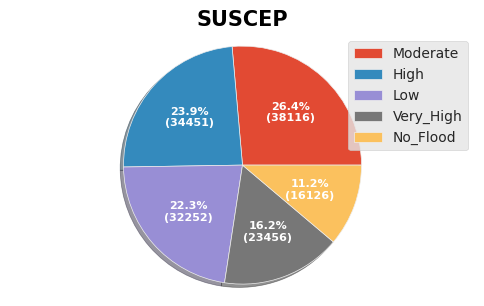

In [ ]:
plt.style.use('ggplot')

def autopct_fun(abs_values):
    gen = iter(abs_values)
    return lambda pct: f"{pct:.1f}%\n({next(gen)})"

fig,ax = plt.subplots(figsize = (6,3.4))

df_class = data['SUSCEP'].value_counts().to_frame()
labels = df_class.index.to_list()
values = df_class.iloc[:,0].to_list()
ax.pie(x = values, labels = labels, autopct=autopct_fun(values), shadow = True, textprops = {'color':'white', 'fontsize':8, 'fontweight':'bold'})
ax.legend(labels, loc = 'best')
ax.set_title('SUSCEP', fontsize = 15, fontweight = "bold", color = "black")
ax.axis('equal')
fig.show()

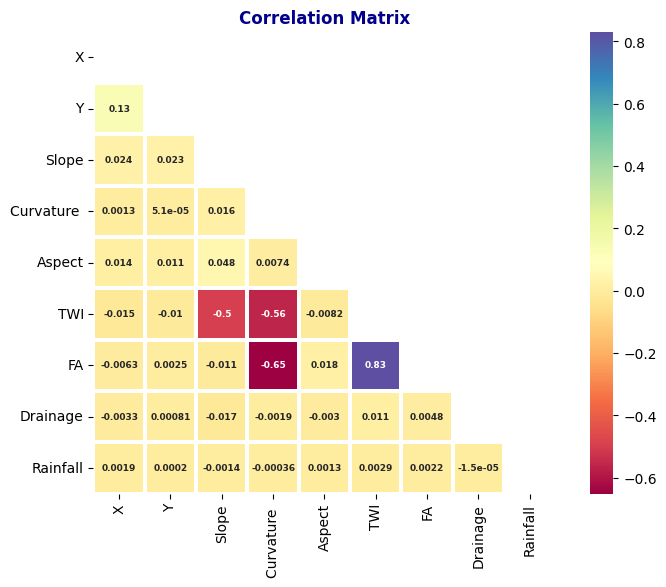

In [ ]:
plt.style.use('default')
corr_matrix_spearman = data[numerical_features].corr(method = 'spearman')
mask = np.triu(np.ones_like(corr_matrix_spearman, dtype = bool))

fig,ax = plt.subplots(figsize = (9, 6))
sns.heatmap(corr_matrix_spearman,
            cmap = 'Spectral',
            annot = True,
            annot_kws = {'fontsize':6.5, 'fontweight':'bold'},
            linewidths = 1.5,
            square = True,
            mask = mask,
            ax = ax)
ax.set_title("Correlation Matrix", fontsize = 12, fontweight = 'bold', color = 'darkblue')
fig.show()

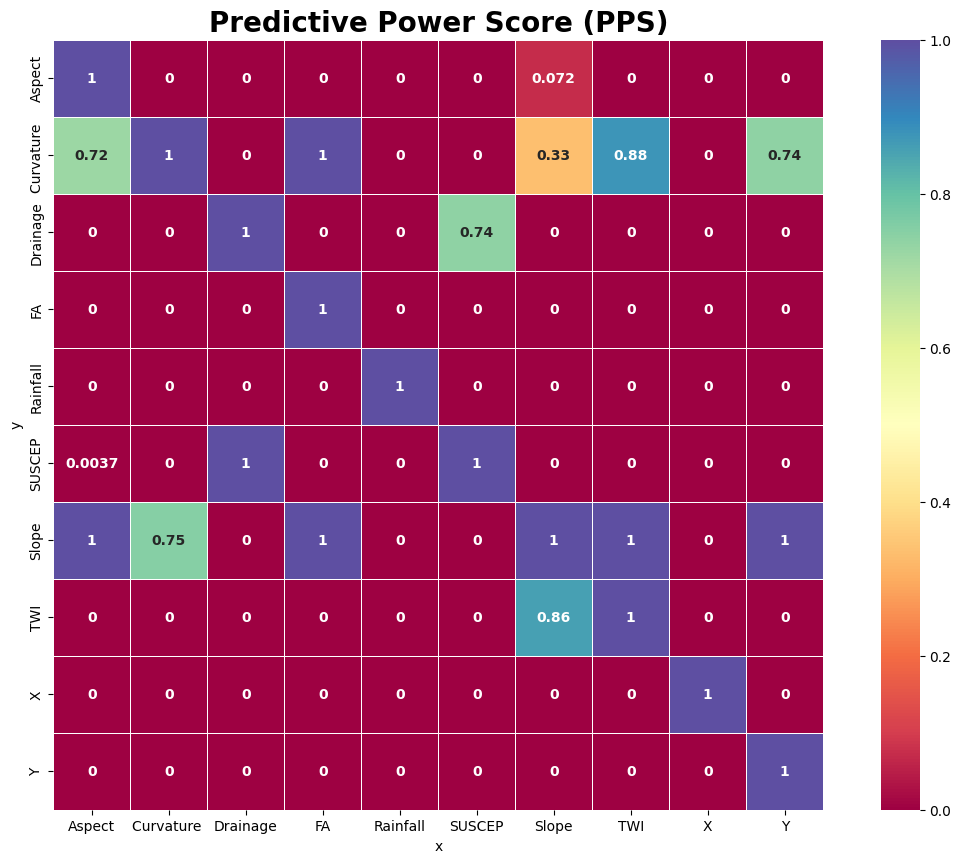

In [ ]:
pps_matrix = pps.matrix(data)[['x','y','ppscore']].pivot(columns = 'x',
                                                         index = 'y',
                                                         values = 'ppscore')


plt.figure(figsize = (15,10))
sns.heatmap(pps_matrix,
            vmin=0,
            vmax=1,
            cmap="Spectral",
            linewidths = 0.5,
            annot=True,
            annot_kws = {'fontsize':10, 'fontweight':'bold'},
            square = True)
plt.title("Predictive Power Score (PPS)", fontsize = 20, fontweight = 'bold', color = 'black')
plt.show()

In [ ]:
df_vif = {}

for i,num_feat in enumerate(numerical_features):
    df_vif[num_feat] = variance_inflation_factor(data[numerical_features].dropna(), i)

df_vif = pd.DataFrame.from_dict(df_vif, orient = 'index').rename(columns = {0:'vif'})
df_vif = df_vif.sort_values('vif', ascending = False)
df_vif.style.background_gradient(cmap = 'coolwarm')

,vif
Slope,19.815661
Curvature,18.536825
FA,1.359543
Aspect,1.327351
TWI,1.129191
Rainfall,0.013950
Drainage,0.001032
X,0.000051
Y,0.000019


In [ ]:
X = data.drop('SUSCEP', axis = 1)
y = data['SUSCEP']

In [ ]:
SEED = 1234

X_train, X_test, y_train, y_test = tts(X,
                                       y,
                                       test_size = 0.3,
                                       random_state = SEED)

In [ ]:
LABELS = ['No_Flood', 'Low', 'Moderate', 'High', 'Very_High']
label2id = dict(zip(LABELS, range(len(LABELS))))
label2id

{'No_Flood': 0, 'Low': 1, 'Moderate': 2, 'High': 3, 'Very_High': 4}

In [ ]:
y_train = y_train.map(label2id)
y_test = y_test.map(label2id)

In [ ]:
y_train.value_counts()

,count
SUSCEP,
2,26707
3,24085
1,22606
4,16363
0,11319


In [ ]:
y_test.value_counts()

,count
SUSCEP,
2,11409
3,10366
1,9646
4,7093
0,4807


In [ ]:
X_train.isnull().sum()

,0
X,0
Y,0
Slope,202
Curvature,0
Aspect,0
TWI,0
FA,0
Drainage,0
Rainfall,0


In [ ]:
X_test.isnull().sum()

,0
X,0
Y,0
Slope,80
Curvature,0
Aspect,0
TWI,0
FA,0
Drainage,0
Rainfall,0


In [ ]:
imputer = SimpleImputer(strategy = 'median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

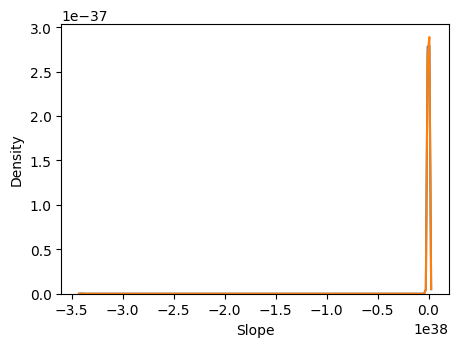

In [ ]:
# We visualize how our variable looked after imputation.
fig,ax = plt.subplots(figsize = (5,3.5))
sns.kdeplot(X_train_imputed[:,2], ax = ax)
sns.kdeplot(data['Slope'], ax = ax)
plt.show()

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [ ]:
lr = LogisticRegression(multi_class = 'multinomial', max_iter = 1000, random_state = SEED, n_jobs = -1)
lr.fit(X_train_scaled, y_train)

y_pred_train_base = lr.predict(X_train_scaled)
y_pred_test_base = lr.predict(X_test_scaled)

print(f'Balanced Accuracy Train: {balanced_accuracy_score(y_train, y_pred_train_base)}')
print(f'Balanced Accuracy Test: {balanced_accuracy_score(y_test, y_pred_test_base)}')

Balanced Accuracy Train: 0.9864903373184541
Balanced Accuracy Test: 0.986731691018929


In [ ]:
# We define the candidate models, we choose the model that best generalizes.
clf1 = RandomForestClassifier(random_state = SEED, n_jobs = -1)
clf2 = ExtraTreesClassifier(bootstrap = True, n_jobs = -1, random_state = SEED)
clf3 = XGBClassifier(random_state = SEED)
clf4 = LGBMClassifier(random_state = SEED, n_jobs = -1, verbosity = -1)
clf5 = CatBoostClassifier(random_state = SEED, verbose = 0)

MODELS = [clf1, clf2, clf3, clf4, clf5]

In [ ]:
# Training!!!
#=====================================================================
accuracy_train = {}
accuracy_test = {}

for model in tqdm_notebook(MODELS):
    name = type(model).__name__
    model.fit(X_train_imputed, y_train)
    y_pred_train = model.predict(X_train_imputed)
    y_pred_test = model.predict(X_test_imputed)
    accuracy_train[name] = balanced_accuracy_score(y_train, y_pred_train)
    accuracy_test[name] = balanced_accuracy_score(y_test, y_pred_test)
    print(f'* {name} finished.')

  0%|          | 0/5 [00:00<?, ?it/s]

* RandomForestClassifier finished.
* ExtraTreesClassifier finished.
* XGBClassifier finished.
* LGBMClassifier finished.
* CatBoostClassifier finished.


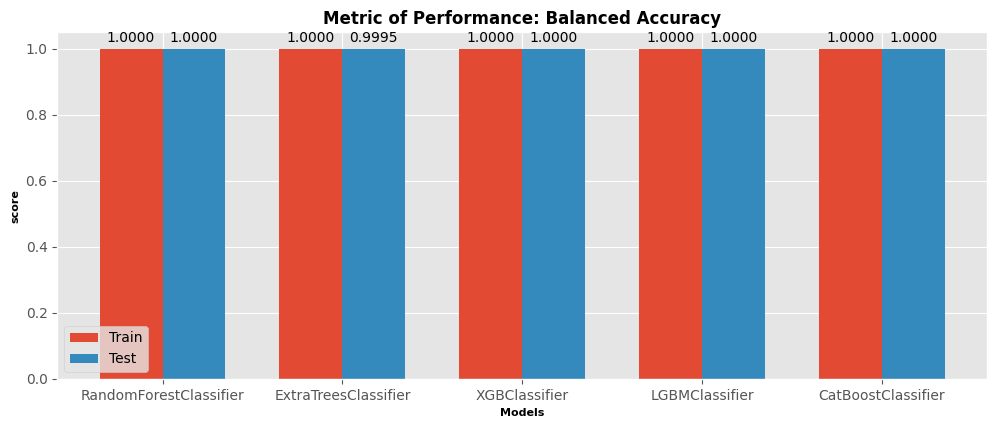

In [ ]:
plt.style.use('ggplot')
metric_train = pd.DataFrame.from_dict(accuracy_train, orient = 'index')
metric_train = metric_train.rename(columns = {0:'Train'})

metric_test = pd.DataFrame.from_dict(accuracy_test, orient = 'index')
metric_test = metric_test.rename(columns = {0:'Test'})

fig,ax = plt.subplots(figsize = (12,4.5))

labels = metric_train.index.to_list()
values_train = metric_train.iloc[:,0].to_list()
values_test = metric_test.iloc[:,0].to_list()
x = np.arange(len(labels))
width = 0.35

rects1 = ax.bar(x = x - width/2, height = values_train, width = width, label = 'Train')
rects2 = ax.bar(x = x + width/2, height = values_test, width = width, label = 'Test')
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(text = f'{height:.4f}',
                    xy = (rect.get_x() + rect.get_width()/2, height),
                    xytext = (0,3),
                    textcoords = "offset points",
                    ha = "center",
                    va = "bottom")

autolabel(rects1)
autolabel(rects2)
ax.legend()
ax.set_title("Metric of Performance: Balanced Accuracy", fontsize = 12, fontweight = "bold", color = "black")
ax.set_ylabel("score", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xlabel("Models", fontsize = 8, fontweight = "bold", color = "black")
ax.set_xticks(x)
ax.set_xticklabels(labels)
fig.show()

In [ ]:
# Predictions !!!
y_pred_train_final = clf3.predict(X_train_imputed)
y_pred_test_final = clf3.predict(X_test_imputed)

In [ ]:
print("##" * 40)
print(" " * 25, "Classification Report Train")
print("##" * 40)
print(classification_report(y_train, y_pred_train_final, target_names = LABELS))
print("")

print("##" * 40)
print(" " * 25, "Classification Report Test")
print("##" * 40)
print(classification_report(y_test, y_pred_test_final, target_names = LABELS))

################################################################################
                          Classification Report Train
################################################################################
              precision    recall  f1-score   support

    No_Flood       1.00      1.00      1.00     11319
         Low       1.00      1.00      1.00     22606
    Moderate       1.00      1.00      1.00     26707
        High       1.00      1.00      1.00     24085
   Very_High       1.00      1.00      1.00     16363

    accuracy                           1.00    101080
   macro avg       1.00      1.00      1.00    101080
weighted avg       1.00      1.00      1.00    101080


################################################################################
                          Classification Report Test
################################################################################
              precision    recall  f1-score   support

    No_Flood       1.00 

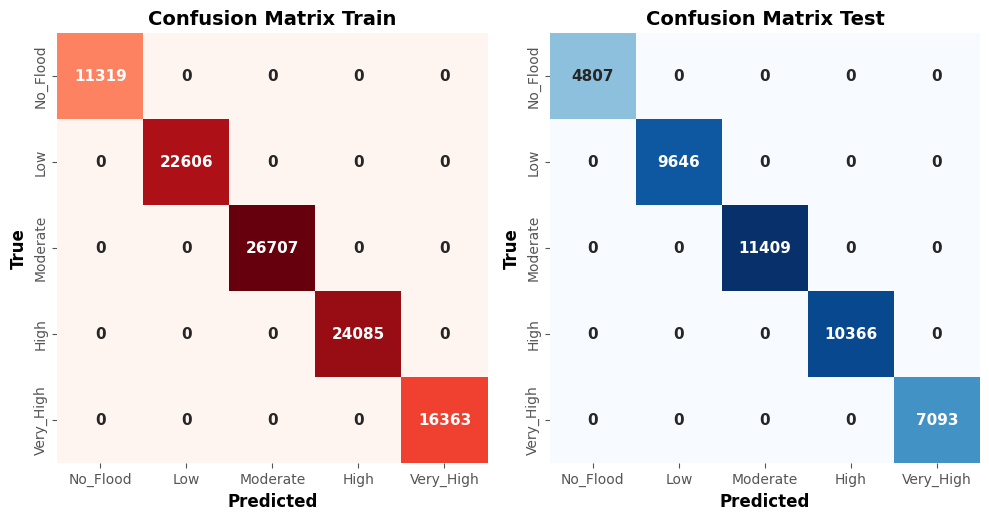

In [ ]:
cf_mx_train = confusion_matrix(y_train, y_pred_train_final)
cf_mx_test = confusion_matrix(y_test, y_pred_test_final)

fig,axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))
axs = axs.flat

sns.heatmap(cf_mx_train, cmap = 'Reds', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', xticklabels = LABELS, yticklabels = LABELS, cbar = False, square = True, ax = axs[0])
sns.heatmap(cf_mx_test, cmap = 'Blues', annot = True, annot_kws = {'fontsize':11, 'fontweight':'bold'}, fmt = '', xticklabels = LABELS, yticklabels = LABELS, cbar = False, square = True, ax = axs[1])
axs[0].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_xlabel('Predicted', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[1].set_ylabel('True', fontsize = 12, fontweight = "bold", color = "black")
axs[0].set_title('Confusion Matrix Train', fontsize = 14, fontweight = "bold", color = "black")
axs[1].set_title('Confusion Matrix Test', fontsize = 14, fontweight = "bold", color = "black")

fig.tight_layout()
fig.show()

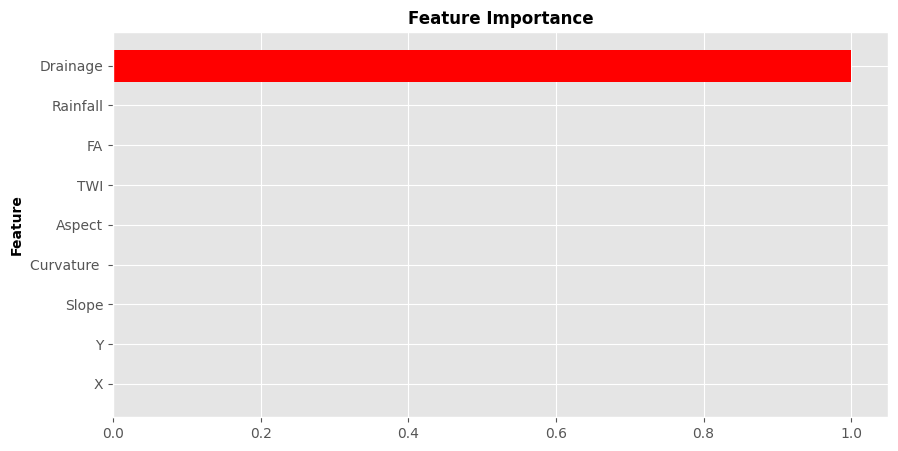

In [ ]:
feature_importance = clf3.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center', color = 'red')
plt.yticks(range(len(sorted_idx)), np.array(imputer.get_feature_names_out())[sorted_idx])
plt.ylabel("Feature", fontsize = 10, fontweight = 'bold', color = 'black')
plt.title('Feature Importance', fontsize = 12, fontweight = 'bold', color = 'black')
plt.show()

# New section